# 🧠 Level 2: Your First AI Object Detection Experience

**Welcome to real Artificial Intelligence!** 🎉

In this notebook, you'll experience **real-time object detection** for the first time. Your camera will **automatically identify objects** in the real world and tell you what it sees!

## 🎯 What You'll Learn
- How AI "sees" and recognizes objects
- What confidence scores mean
- How bounding boxes work
- Why the IMX500 camera is special

## 🔧 What You'll Need
- Sony IMX500 AI Camera connected to your Pi
- Some objects to detect (phone, cup, book, etc.)
- Good lighting for best results

---

## 📚 Understanding AI Object Detection

**What is Object Detection?**

Imagine you're looking at a photo and someone asks you:
- "What objects do you see?"
- "Where exactly are they in the photo?"
- "How sure are you that's really a cup?"

That's exactly what AI object detection does! It:
1. **Identifies** what objects are in the image
2. **Locates** where each object is (draws boxes around them)
3. **Estimates** how confident it is about each detection

**Why is the IMX500 Special?**

Most cameras just capture images. The IMX500 is **smart** - it has a tiny computer built right into the sensor that runs AI models at incredible speed!

- **🚀 Super Fast**: Processes AI at 30 frames per second
- **⚡ Efficient**: Your Pi CPU stays cool and available
- **🎯 Accurate**: Uses proven MobileNet SSD architecture
- **📦 Ready-to-Use**: No complex setup required

## 🔥 Let's Start Detecting!

Run the cell below to start your first AI object detection experience:

In [1]:
import subprocess
import cv2
import numpy as np
from IPython.display import display, clear_output, Image
import ipywidgets as widgets
import threading
import time
import json

# ── Setup: Clean any existing camera processes
print("🔧 Setting up AI camera...")
for p in ("libcamera-vid", "libcamera-still", "libcamera-raw"):
    subprocess.run(["pkill", "-9", p], stderr=subprocess.DEVNULL)
subprocess.run(["sudo", "rmmod", "bcm2835_v4l2"], stderr=subprocess.DEVNULL)

print("✅ Camera setup complete!")
print("\n🤖 Starting AI Object Detection...")
print("\n📱 Try pointing the camera at:")
print("   • Your phone or laptop")
print("   • A cup or bottle")
print("   • A book or notebook")
print("   • Your hand (detects as 'person')")
print("   • Any household objects!")

# Create stop button
stop_button = widgets.ToggleButton(
    value=False,
    description='⏹️ Stop AI Detection',
    button_style='danger',
    layout=widgets.Layout(width='200px', height='40px')
)

# Create status display
status_output = widgets.Output()

display(widgets.VBox([stop_button, status_output]))

🔧 Setting up AI camera...
✅ Camera setup complete!

🤖 Starting AI Object Detection...

📱 Try pointing the camera at:
   • Your phone or laptop
   • A cup or bottle
   • A book or notebook
   • Your hand (detects as 'person')
   • Any household objects!


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



🚀 AI Object Detection is now running!

👀 Watch the image above - you should see:
   🔲 Colored boxes around detected objects
   🏷️ Object names (like 'person', 'cell phone', 'cup')
   📊 Confidence scores (like 85%, 92%)

⏹️ Click 'Stop AI Detection' when you're done exploring!


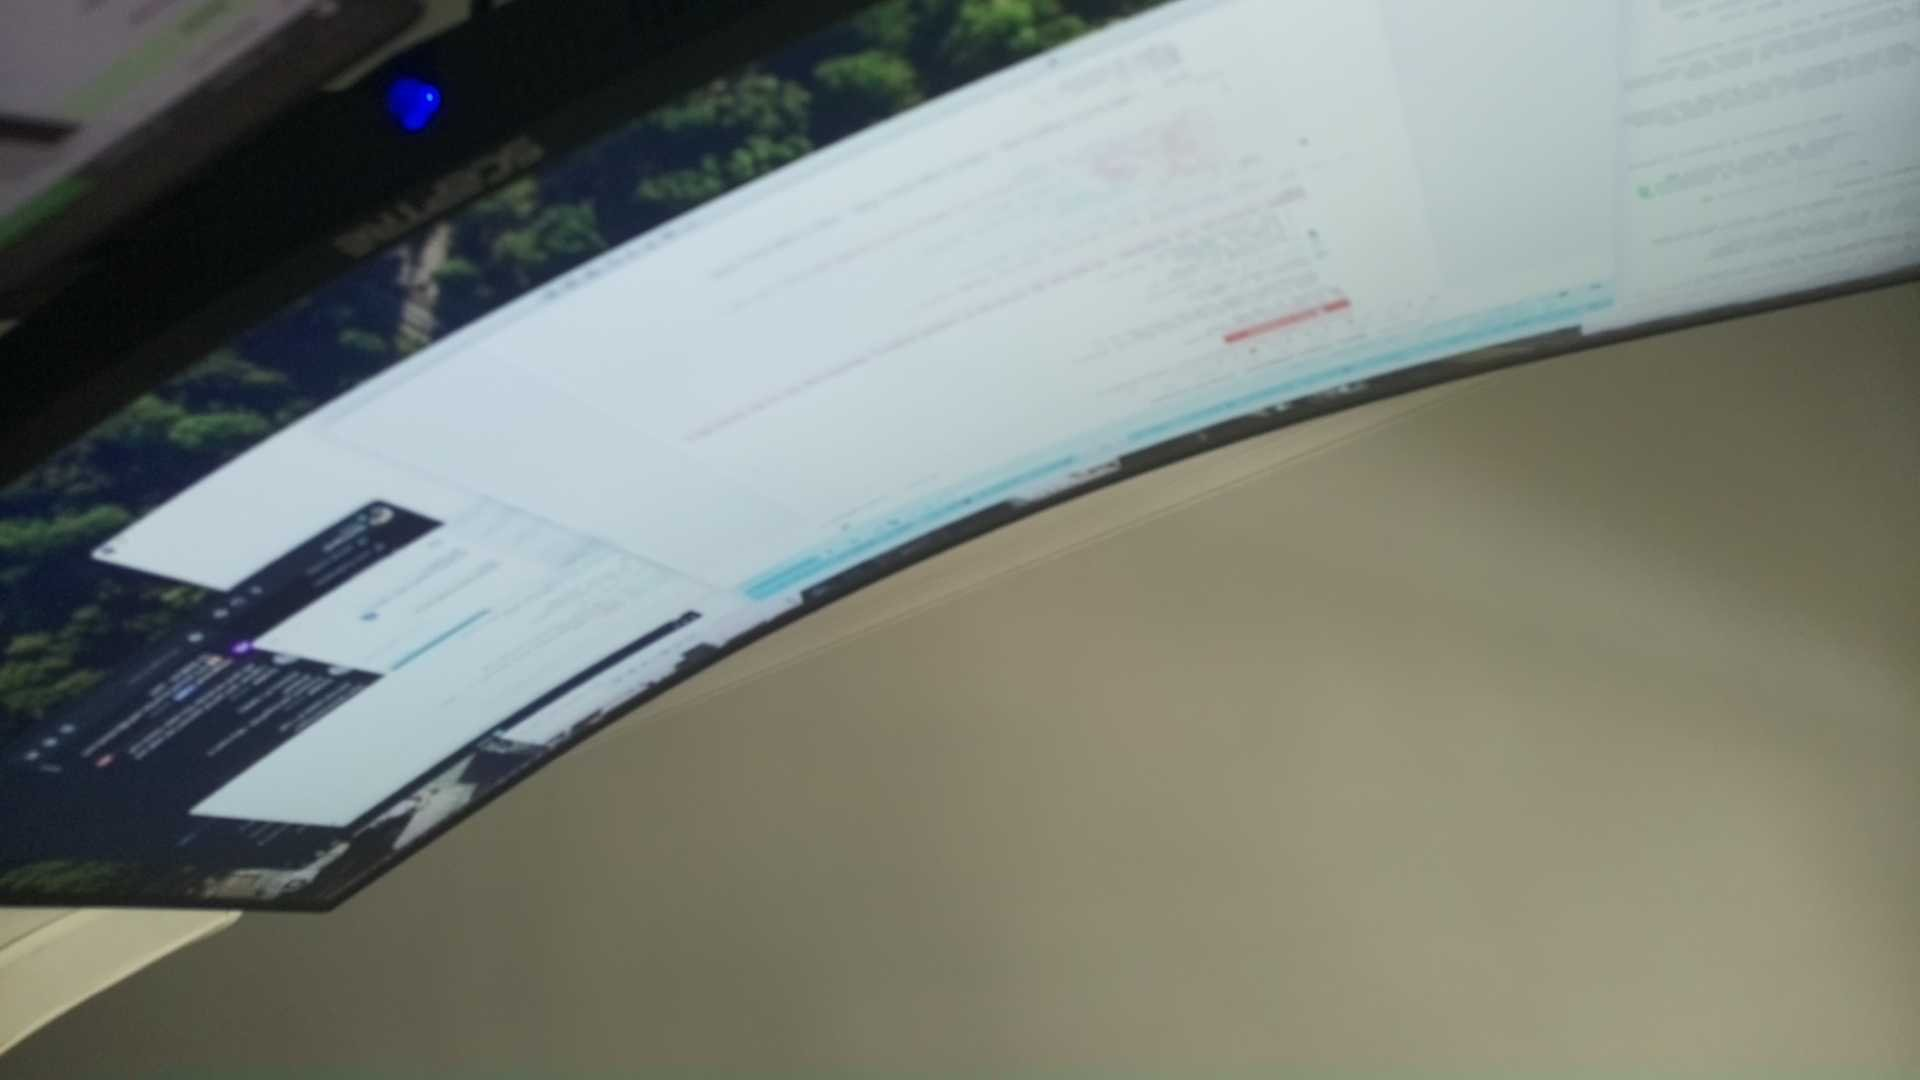

In [2]:
def run_ai_detection():
    """Run real-time AI object detection with the IMX500 camera"""
    
    # Use the MobileNet SSD model for object detection
    cmd = [
        "rpicam-vid",
        "--inline",  # Stream output
        "-t", "0",    # No timeout
        "--width", "1920",   # Full HD for great quality
        "--height", "1080",
        "--framerate", "30",  # Smooth 30fps
        "--codec", "mjpeg",
        "--post-process-file", "/usr/share/rpi-camera-assets/imx500_mobilenet_ssd.json",
        "-o", "-"  # Output to stdout
    ]
    
    try:
        proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        
        data = b""
        detection_count = 0
        frames_processed = 0
        
        # Create display handle for updating the same image area
        display_handle = display(None, display_id=True)
        
        with status_output:
            clear_output(wait=True)
            print("🎯 AI Detection Status: ACTIVE")
            print("📊 Processing frames...")
        
        while not stop_button.value:
            chunk = proc.stdout.read(4096)  # Read larger chunks for better performance
            if not chunk:
                break
                
            data += chunk
            
            # Look for complete JPEG frames
            start = data.find(b'\xff\xd8')  # JPEG start marker
            end = data.find(b'\xff\xd9')    # JPEG end marker
            
            if start != -1 and end != -1:
                # Extract the JPEG frame
                jpg_data = data[start:end+2]
                data = data[end+2:]  # Keep remaining data for next frame
                
                try:
                    # Decode and display the frame
                    frame = cv2.imdecode(np.frombuffer(jpg_data, dtype=np.uint8), cv2.IMREAD_COLOR)
                    if frame is not None:
                        # Re-encode for display
                        _, display_jpg = cv2.imencode('.jpg', frame, [cv2.IMWRITE_JPEG_QUALITY, 85])
                        display_handle.update(Image(data=display_jpg.tobytes()))
                        
                        frames_processed += 1
                        
                        # Update status every 30 frames (roughly every second)
                        if frames_processed % 30 == 0:
                            with status_output:
                                clear_output(wait=True)
                                print(f"🎯 AI Detection Status: ACTIVE")
                                print(f"📊 Frames processed: {frames_processed}")
                                print(f"⚡ Running at ~30 FPS")
                                print(f"\n💡 Look for colored boxes around detected objects!")
                                print(f"💡 Object names appear above each box")
                                print(f"💡 Confidence scores show how sure the AI is")
                        
                except Exception as e:
                    # Skip corrupted frames
                    continue
            
            # Small delay to prevent overwhelming the system
            time.sleep(0.001)
            
    except Exception as e:
        with status_output:
            clear_output(wait=True)
            print(f"❌ Error: {str(e)}")
            print("\n🔧 Troubleshooting:")
            print("   • Make sure IMX500 camera is connected")
            print("   • Try restarting the notebook kernel")
            print("   • Check camera with: rpicam-hello -t 5000")
    
    finally:
        # Clean up
        try:
            proc.terminate()
            proc.wait(timeout=2)
        except:
            proc.kill()
        
        with status_output:
            clear_output(wait=True)
            print("⏹️ AI Detection stopped")
            print(f"📊 Total frames processed: {frames_processed}")

# Start AI detection in a separate thread
detection_thread = threading.Thread(target=run_ai_detection, daemon=True)
detection_thread.start()

print("\n🚀 AI Object Detection is now running!")
print("\n👀 Watch the image above - you should see:")
print("   🔲 Colored boxes around detected objects")
print("   🏷️ Object names (like 'person', 'cell phone', 'cup')")
print("   📊 Confidence scores (like 85%, 92%)")
print("\n⏹️ Click 'Stop AI Detection' when you're done exploring!")

## 🎉 Congratulations!

You just ran **real artificial intelligence** on your Raspberry Pi! Here's what just happened:

### 🧠 The Magic Behind the Scenes

1. **AI Model**: Your camera used **MobileNet SSD** - a neural network trained on millions of images
2. **On-Sensor Processing**: The AI runs directly on the IMX500 chip, not your Pi's CPU!
3. **Real-Time Speed**: 30 frames per second of AI analysis
4. **80 Object Types**: Can detect phones, cups, people, cars, and much more

### 🔍 What Did You Notice?

**Bounding Boxes**: The colored rectangles around objects
- Show exactly where the AI "sees" each object
- Different colors for different object types

**Object Labels**: The text above each box
- Shows what the AI thinks the object is
- Based on training from millions of example images

**Confidence Scores**: The percentages you saw
- How "sure" the AI is about each detection
- Higher = more confident (85% vs 45%)

---

## 🧪 Quick Experiment

Before moving on, try this fun experiment to understand how AI "sees" differently than humans:

In [ ]:
# Quick AI Understanding Test
print("🧪 AI UNDERSTANDING EXPERIMENT")
print("="*40)
print("\n📝 What did you observe? (Think about these questions)")
print("\n1. 🎯 ACCURACY QUESTIONS:")
print("   • Did the AI correctly identify most objects?")
print("   • What objects was it most confident about?")
print("   • Did it ever mistake one object for another?")

print("\n2. 🔍 DETECTION QUESTIONS:")
print("   • How close did you need to hold objects?")
print("   • Did lighting affect the detections?")
print("   • What happened when you moved objects quickly?")

print("\n3. 🧠 AI BEHAVIOR QUESTIONS:")
print("   • Did confidence scores change as you moved objects?")
print("   • What was the lowest confidence score you saw?")
print("   • Did it detect partial objects (like half a cup)?")

print("\n💡 These observations help you understand:")
print("   ✓ AI has strengths and limitations")
print("   ✓ Confidence scores matter for real applications")
print("   ✓ Environmental factors affect AI performance")

print("\n🎓 You're now ready for Level 2.2: Understanding AI Results!")

## 🚀 What's Next?

Amazing work! You've successfully:
- ✅ Experienced real-time AI object detection
- ✅ Learned about bounding boxes and confidence scores
- ✅ Understood how the IMX500 processes AI on-sensor

### 📚 Continue Your AI Journey:

**Next Notebook**: `Understanding_Results.ipynb`
- Deep dive into confidence scores
- Learn when to trust AI predictions
- Understand detection thresholds

**Then Try**: `Detection_Experiments.ipynb`
- Test different objects and scenarios
- Explore detection limits and capabilities
- Learn about environmental factors

---

### 🎯 Key Takeaways

1. **AI is Fast**: 30fps real-time detection on a tiny Pi Zero 2W!
2. **AI is Smart**: Recognizes 80+ different object types
3. **AI is Honest**: Gives confidence scores, not just guesses
4. **AI is Practical**: Ready to use in real applications

**You're now officially an AI practitioner!** 🎉🤖